# [G-16] 커스텀프로젝트

## Import

In [56]:
# !pip install scikit-multilearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 89 kB 4.3 MB/s            


In [134]:
import os
import re
import gc
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import tensorflow as tf
import sentencepiece as spm
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline, set_seed
from transformers import DataCollatorWithPadding

import datasets
from datasets import Dataset, DatasetDict
from datasets import load_metric
from datasets import ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

import missingno as msno

## Step1 : Data 불러오기 및 전처리 작업

### data 불러오기

In [2]:
train_data = pd.read_table("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_data = pd.read_table("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(len(train_data['document'][0]))

19


### 문자 길이 개수

In [6]:
def sentence_len(sentence):
    st_len = []
    for i in range(len(sentence['document'])):
        st_test_len = len(str(sentence['document'][i]))
        st_len.append(st_test_len)
        
    print("최대 길이 값 : ", max(st_len))
    print("최소 길이 값 : ", min(st_len))

In [7]:
sentence_len(train_data)

최대 길이 값 :  146
최소 길이 값 :  1


In [8]:
sentence_len(test_data)

최대 길이 값 :  144
최소 길이 값 :  1


### 결측값 확인 및 제거

In [9]:
print(train_data.isnull().sum())
print('--------------')
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
--------------
id          0
document    3
label       0
dtype: int64


<AxesSubplot:>

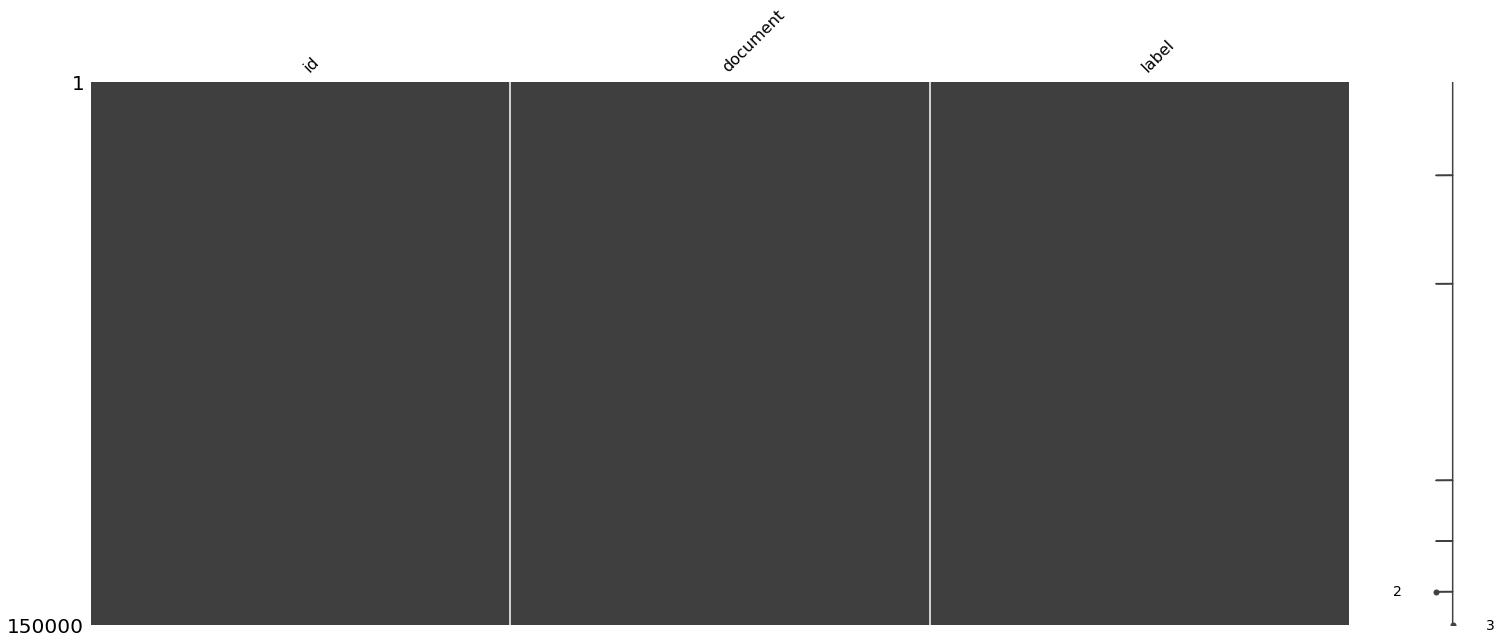

In [10]:
msno.matrix(train_data)

<AxesSubplot:>

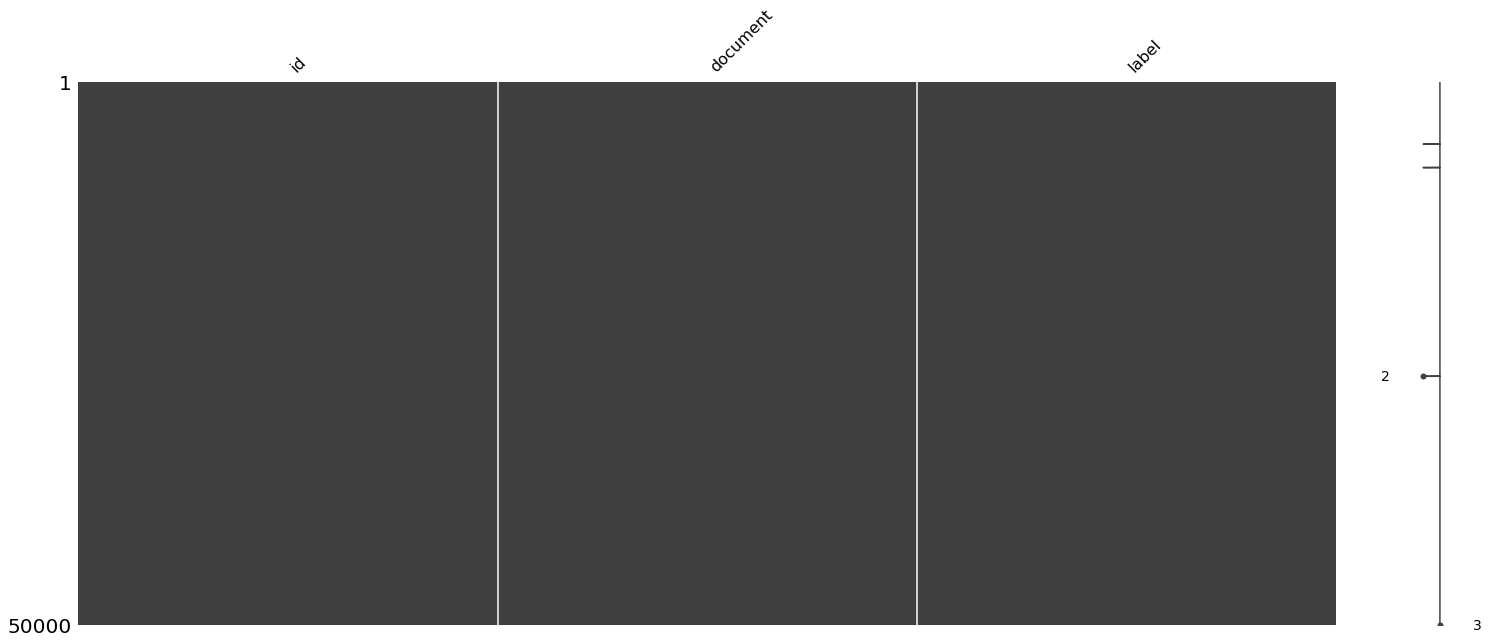

In [11]:
msno.matrix(test_data)

In [12]:
train_data.dropna(axis=0, how='any', inplace = True)

In [13]:
test_data.dropna(axis=0, how='any', inplace = True)

In [14]:
print(train_data.isnull().sum())
print('--------------')
print(test_data.isnull().sum())

id          0
document    0
label       0
dtype: int64
--------------
id          0
document    0
label       0
dtype: int64


### 중복제거

In [15]:
train_data.drop_duplicates(['document'], keep='first', inplace=True, ignore_index=True)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146182 entries, 0 to 146181
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ MB


In [17]:
test_data.drop_duplicates(['document'], keep='first', inplace=True, ignore_index=True)

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49157 entries, 0 to 49156
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [19]:
sentence_len(train_data)

최대 길이 값 :  146
최소 길이 값 :  1


In [20]:
sentence_len(test_data)

최대 길이 값 :  144
최소 길이 값 :  1


## Step2 : Tokenizing (Sentence piece or klue/bert-base)

### Tokenizing 전 정규화

In [21]:
all_doc = np.concatenate((train_data['document'].values,test_data['document'].values))

def clean_sentence(sentence):
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z!.,?]+", " ", sentence)
        return sentence

filtered_corpus = []
for i in all_doc :
    sentence = clean_sentence(i)
    filtered_corpus.append(sentence)

train_f = filtered_corpus[:146182]
test_f = filtered_corpus[146182:]
all_doc_f = np.concatenate((train_f,test_f))

In [22]:
print(train_f[:5])
print('------------------------------')
print(test_f[:5])

['아 더빙 . . 진짜 짜증나네요 목소리', '흠 . . . 포스터보고 초딩영화줄 . . . . 오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 . . 솔직히 재미는 없다 . . 평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화 ! 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']
------------------------------
['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은 . . . . 나쁘진 않지만 점 짜리는 더더욱 아니잖아', '지루하지는 않은데 완전 막장임 . . . 돈주고 보기에는 . . . . ', ' D만 아니었어도 별 다섯 개 줬을텐데 . . 왜 D로 나와서 제 심기를 불편하게 하죠 ? ? ']


In [23]:
with open('test.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(all_doc_f))

### sentence piece tokenizer

In [24]:
spm.SentencePieceTrainer.Train('--input=test.txt --model_prefix=st_data --vocab_size=35000 --model_type=char --max_sentence_length=9999')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=test.txt --model_prefix=st_data --vocab_size=35000 --model_type=char --max_sentence_length=9999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: test.txt
  input_format: 
  model_prefix: st_data
  model_type: CHAR
  vocab_size: 35000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 9999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
 

In [25]:
sp = spm.SentencePieceProcessor()
vocab_file = "st_data.model"
sp.load(vocab_file)

True

In [26]:
test_sentence_piece = "오늘의 날씨는 맑아요"
print(sp.encode_as_pieces(test_sentence_piece))

['▁', '오', '늘', '의', '▁', '날', '씨', '는', '▁', '맑', '아', '요']


### klue/bert-base tokenizer

In [27]:
model_ckpt = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [28]:
test_klue_bert = "오늘의 날씨는 맑아요"
test_klue = tokenizer(test_klue_bert).tokens()
print(test_klue)

['[CLS]', '오늘', '##의', '날씨', '##는', '맑', '##아', '##요', '[SEP]']


In [29]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_additional_special_tokens',
 '_batch_encode_plus',
 '_bos_token',
 '_cls_token',
 '_convert_encoding',
 '_convert_id_to_token',
 '_convert_token_to_id_with_added_voc',
 '_create_or_get_repo',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_from_pretrained',
 '_get_padding_truncation_strategies',
 '_get_repo_url_from_name',
 '_mask_token',
 '_pad',
 '_pad_token',
 '_pad_token_type_id',
 '_push_to_hub',
 '_save_pretrained',
 '_sep_token',
 '_tokenizer',
 '_un

In [30]:
print(len(train_f) == len(train_data['label']))
print(len(test_f) == len(test_data['label']))

True
True


In [31]:
tokenizer.model_max_length

512

In [32]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [34]:
train_ = pd.DataFrame({'values' : train_f, 'label' : train_data['label']}).reset_index(drop=True)
test_ = pd.DataFrame({'values' : test_f, 'label' : test_data['label']}).reset_index(drop=True)

# 데이터줄이기...
train_ = train_.sample(15000, random_state=123).reset_index(drop=True)
test_ = test_.sample(1000, random_state=123).reset_index(drop=True)

In [35]:
train_d = Dataset.from_pandas(train_)
test_d = Dataset.from_pandas(test_)

# datasetdict형태로 transformation
dataset = datasets.DatasetDict({"train":train_d,"test":test_d})

In [36]:
#int2str 사용 가능하게 label 값을 classlabel 객채로 변환, 
dataset['train'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

dataset['test'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

In [37]:
# 데이터 값 최종 확인
dataset.set_format(type='pandas')
df = dataset['train'][:]

In [38]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,values,label,label_name
0,세월을 무시하는 상콤한 하이틴무비,1,positive
1,일베충은 보고 반성할것,1,positive
2,대만ㅅㅁ섬짱개들 이따구 쓰레기영화 만들거잇네이따걸왜 상영허냐 ! ! !,0,negative
3,역시 한국 영화다 보니까 스토리가좀,0,negative
4,평점을 보니 초딩들에게는 점짜리 영화인 듯,0,negative


In [39]:
# 인코딩하여 최종 데이터 dict 저장
dataset.set_format(type=None)
def tokenize(batch):
    return tokenizer(batch['values'], padding=True, truncation=True)

In [40]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [110]:
print(dataset_encoded.column_names)
print(dataset_encoded["train"].column_names)

{'train': ['attention_mask', 'input_ids', 'label', 'token_type_ids', 'values'], 'test': ['attention_mask', 'input_ids', 'label', 'token_type_ids', 'values']}
['attention_mask', 'input_ids', 'label', 'token_type_ids', 'values']


In [42]:
data_collator =  DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

## Step3 : Model (klue/bert-base)

### BaseModel

In [44]:
model_ckpt = "klue/bert-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### hidden states 출력

In [45]:
def extract_hidden_states(batch):
    # 모델 입력 -> GPU
    inputs = {k:v for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # hidden states 출력
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [46]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [47]:
# # CPU에 있는 텐서 
# dataset_encoded.is_cuda  # returns False

In [48]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [59]:
dataset_hidden.column_names

{'train': ['attention_mask',
  'hidden_state',
  'input_ids',
  'label',
  'token_type_ids',
  'values'],
 'test': ['attention_mask',
  'hidden_state',
  'input_ids',
  'label',
  'token_type_ids',
  'values']}

In [49]:
dataset_hidden["train"].column_names

['attention_mask',
 'hidden_state',
 'input_ids',
 'label',
 'token_type_ids',
 'values']

In [63]:
print(dataset_hidden["test"]["label"])

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

### 나이브 베이즈 모델 (Base model)

In [52]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [67]:
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_valid = np.array(dataset_hidden['test']['hidden_state'])
y_train = np.array(dataset_hidden['train']['label'])
y_valid = np.array(dataset_hidden['test']['label'])
print(X_train.shape, X_valid.shape)

(15000, 768) (1000, 768)


In [69]:
base_model = BernoulliNB()
base_model.fit(X_train, y_train)

BernoulliNB()

In [75]:
prediction = base_model.predict(X_valid)
classification = classification_report(y_valid, prediction)
print(classification)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       528
           1       0.79      0.75      0.77       472

    accuracy                           0.79      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.79      0.79      1000



### Finetuning model

In [127]:
num_labels = 2
num_epochs = 5
batch_size = 32
model_ckpt = "klue/bert-base"

In [105]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

dataset_config = AutoConfig.from_pretrained(model_ckpt,
                                            num_labels = num_labels,
                                            id2label = id2label,
                                            label2id = label2id)

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                           config=dataset_config).to(device)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [128]:
args = TrainingArguments(
    output_dir = 'data_test',
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    save_steps=1e6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    disable_tqdm=True,
    load_best_model_at_end=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [129]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy" : acc, "f1" : f1}

In [130]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=dataset_config).to(device)

In [131]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transformers/05b36ee62545d769939a7746eca739b844a40a7a7553700f110b58b28ed6a949.7cb231256a5dbe886e12b902d05cb1241f330d8c19428508f91b2b28c1cfe0b6
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

In [132]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

* 메모리 확보 코드

In [133]:
trainer.train()

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transformers/05b36ee62545d769939a7746eca739b844a40a7a7553700f110b58b28ed6a949.7cb231256a5dbe886e12b902d05cb1241f330d8c19428508f91b2b28c1cfe0b6
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

{'eval_loss': 0.3204146921634674, 'eval_accuracy': 0.86, 'eval_f1': 0.8600897435897437, 'eval_runtime': 6.2246, 'eval_samples_per_second': 160.653, 'eval_steps_per_second': 5.141, 'epoch': 1.0}


Model weights saved in data_test/checkpoint-469/pytorch_model.bin
tokenizer config file saved in data_test/checkpoint-469/tokenizer_config.json
Special tokens file saved in data_test/checkpoint-469/special_tokens_map.json


{'loss': 0.3534, 'learning_rate': 1.5735607675906184e-05, 'epoch': 1.07}


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: values.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to data_test/checkpoint-938
Configuration saved in data_test/checkpoint-938/config.json


{'eval_loss': 0.3466455042362213, 'eval_accuracy': 0.86, 'eval_f1': 0.8601047707090232, 'eval_runtime': 6.1281, 'eval_samples_per_second': 163.183, 'eval_steps_per_second': 5.222, 'epoch': 2.0}


Model weights saved in data_test/checkpoint-938/pytorch_model.bin
tokenizer config file saved in data_test/checkpoint-938/tokenizer_config.json
Special tokens file saved in data_test/checkpoint-938/special_tokens_map.json


{'loss': 0.2169, 'learning_rate': 1.1471215351812369e-05, 'epoch': 2.13}


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: values.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to data_test/checkpoint-1407
Configuration saved in data_test/checkpoint-1407/config.json


{'eval_loss': 0.4347712993621826, 'eval_accuracy': 0.853, 'eval_f1': 0.8529136401295473, 'eval_runtime': 6.1181, 'eval_samples_per_second': 163.448, 'eval_steps_per_second': 5.23, 'epoch': 3.0}


Model weights saved in data_test/checkpoint-1407/pytorch_model.bin
tokenizer config file saved in data_test/checkpoint-1407/tokenizer_config.json
Special tokens file saved in data_test/checkpoint-1407/special_tokens_map.json


{'loss': 0.1364, 'learning_rate': 7.20682302771855e-06, 'epoch': 3.2}


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: values.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to data_test/checkpoint-1876
Configuration saved in data_test/checkpoint-1876/config.json


{'eval_loss': 0.5393721461296082, 'eval_accuracy': 0.861, 'eval_f1': 0.8611056160158413, 'eval_runtime': 6.1202, 'eval_samples_per_second': 163.393, 'eval_steps_per_second': 5.229, 'epoch': 4.0}


Model weights saved in data_test/checkpoint-1876/pytorch_model.bin
tokenizer config file saved in data_test/checkpoint-1876/tokenizer_config.json
Special tokens file saved in data_test/checkpoint-1876/special_tokens_map.json


{'loss': 0.0782, 'learning_rate': 2.9424307036247335e-06, 'epoch': 4.26}


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: values.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to data_test/checkpoint-2345
Configuration saved in data_test/checkpoint-2345/config.json


{'eval_loss': 0.5843184590339661, 'eval_accuracy': 0.862, 'eval_f1': 0.8621077128138622, 'eval_runtime': 6.0973, 'eval_samples_per_second': 164.007, 'eval_steps_per_second': 5.248, 'epoch': 5.0}


Model weights saved in data_test/checkpoint-2345/pytorch_model.bin
tokenizer config file saved in data_test/checkpoint-2345/tokenizer_config.json
Special tokens file saved in data_test/checkpoint-2345/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from data_test/checkpoint-469 (score: 0.3204146921634674).


{'train_runtime': 1549.8637, 'train_samples_per_second': 48.391, 'train_steps_per_second': 1.513, 'train_loss': 0.17691892693037672, 'epoch': 5.0}


TrainOutput(global_step=2345, training_loss=0.17691892693037672, metrics={'train_runtime': 1549.8637, 'train_samples_per_second': 48.391, 'train_steps_per_second': 1.513, 'train_loss': 0.17691892693037672, 'epoch': 5.0})

In [135]:
gc.collect()

9

* 메모리 공간 확인

In [126]:
# best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

* n_trials를 조절하여 grid search를 하는 횟수를 조절 가능(https://dacon.io/en/competitions/official/235747/codeshare/3047?page=1&dtype=recent)

### Freezing test

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                           config=dataset_config).to(device)

for name, param in model.named_parameters():
    if name.startswith("bert.encoder.layer"): # choose whatever you like here
        param.requires_grad = False
    print(name, param.requires_grad)

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transformers/05b36ee62545d769939a7746eca739b844a40a7a7553700f110b58b28ed6a949.7cb231256a5dbe886e12b902d05cb1241f330d8c19428508f91b2b28c1cfe0b6
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay